# Learning how to use MCA code
The goal of this is for it to hopefully replace GRAE. 

In [1]:
#Imports 
import numpy as np
import random

import numpy as np
import matplotlib.pyplot as plt

import csv
from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression

import sklearn
from sklearn import datasets

#Added by Adam. (Changed all the cuda code to work more generally across all systems)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

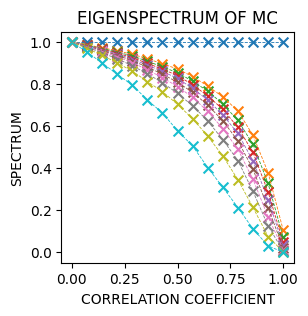

In [2]:
#### CODES BLOW ARE THE EIGENSPECTRUM ####

# Set a seed for reproducibility of the random operations
np.random.seed(5)

num_state = 10  # Define the number of states in the Markov chain

# Initialize lists to store samples and eigenvalue spectra for later analysis
SAMPLE_X_LIST = []
SAMPLE_Y_LIST = []
EIGEN_LIST = []

# First loop to simulate different realizations (100 total) of the Markov chain
for j in range(0, 100):
  # Nested loop cycles through 15 different correlation coefficients from 0 to 1
  for k in np.linspace(0, 1, 15):
    # 1. Create a transition matrix with random entries scaled by k/num_state
    transition_matrix = np.array([[random.uniform(0, k/num_state) for i in range(num_state)] for j in range(num_state)])
    
    # 2. Adjust diagonal elements to guarantee a self-loop bias that depends on k and the state index
    for j, r in enumerate(transition_matrix):
        r[j] += 1*(1-k) + (j/10)*(1-k)*10

    # 3. Normalize the transition matrix so that each row sums to one (proper probability distribution)
    transition_matrix = transition_matrix/transition_matrix.sum(1).reshape(-1, 1)

    # 4. Compute the joint probability matrix by multiplying a uniform distribution (p_x) with the transition matrix
    py_x = np.array(transition_matrix)
    p_x = np.array([1/num_state]*num_state)  # uniform distribution for the initial state
    p_x = p_x/p_x.sum(0)
    
    # 5. Compute the marginal distribution on y by summing along the states of the transition matrix
    p_y = (p_x.reshape(-1, 1)*transition_matrix).sum(0)
    
    # 6. Calculate the joint probability distribution p(x,y)
    pxy = p_x.reshape(-1, 1)*py_x

    # 7. Compute the conditional probability distribution p(x|y)
    px_y = (pxy/p_y.reshape(1, -1)).T
    
    # 8. Reconstruct a matrix that correlates the joint probabilities with the conditional distribution
    # Essentially, this forms a kernel that captures the connection between x and y
    px_x = pxy@px_y
    
    # 9. Build an outer product for the independent probabilities
    pxx = p_x.reshape(-1, 1)*p_x.reshape(1, -1)
    
    # 10. Construct a symmetric positive semi-definite kernel matrix by normalizing with the outer product
    psd_kernel = px_x/pxx**(1/2)

    # 11. Obtain the eigenvalues and eigenvectors from the kernel (which will give the spectrum)
    true_eigv, true_eigvec = np.linalg.eig(psd_kernel)
    index_sort = true_eigv.argsort()[::-1]  # Sort eigenvalues in descending order
    true_eigv = true_eigv[index_sort]
    true_eigvec = true_eigvec[:, index_sort]

    # 12. Compute the ratio and scale the eigenvectors with the square root of the initial distribution
    true_ratio = px_x/pxx
    true_function = true_eigvec*p_x.reshape(-1, 1)**(1/2)

    # 13. Generate one random sample according to the joint distribution p(x,y)
    data = np.random.choice(np.arange(0, pxy.reshape(-1).shape[0]), size=(1), p=pxy.reshape(-1))

    # 14. Create an index list of all (x, y) state pairs for mapping the sample index to actual states
    index_list = []
    for i in range(0, num_state):
        for j in range(0, num_state):
            index_list.append((i, j))

    # 15. Map the random sample index to its corresponding (x,y) pair
    data = np.array(index_list)[data]
    X = data[:, 0]
    Y = data[:, 1]

    # 16. Convert the sampled states (X and Y) to one-hot encoded tensors
    SAMPLE_X = torch.nn.functional.one_hot(torch.from_numpy(X).view(-1).to(torch.int64), num_classes=num_state).float().view(X.shape[0], -1)
    SAMPLE_Y = torch.nn.functional.one_hot(torch.from_numpy(Y).view(-1).to(torch.int64), num_classes=num_state).float().view(Y.shape[0], -1)

    # 17. Store the current samples and eigenvalues for later use and analysis
    SAMPLE_X_LIST.append(SAMPLE_X)
    SAMPLE_Y_LIST.append(SAMPLE_Y)
    EIGEN_LIST.append(true_eigv)

# 18. Compute the average eigenvalue spectrum over all the 100 x 15 cases simulated
mean_eig = np.array(EIGEN_LIST).reshape(-1, 15, 10).mean(0)

# 19. Plot the averaged eigenvalue spectrum versus the correlation coefficient (k values)
plt.figure(figsize=(3, 3))
for k in range(0, 10, 1):
  plt.scatter(np.linspace(0, 1, 15), mean_eig[:, k], marker='x', s=50)
  plt.plot(np.linspace(0, 1, 15), mean_eig[:, k], linewidth=0.6, linestyle='--')
plt.title('EIGENSPECTRUM OF MC')
plt.xlabel('CORRELATION COEFFICIENT')
plt.ylabel('SPECTRUM')
plt.show()

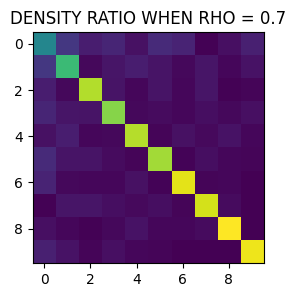

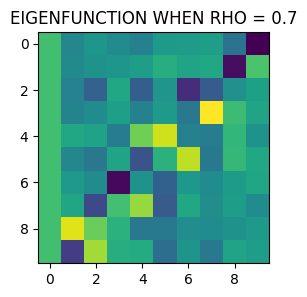

In [3]:
#### CODES BLOW ARE THE EIGENFUNCTION AND DENSITY RATIO ####
"""
This module simulates a Markov chain with a specified number of states and computes both the eigenfunctions
and the density ratio of the corresponding probability transition kernel.

Conceptual Overview:
--------------------
1. Initialization:
  - Define the number of discrete states (num_state) for the Markov chain.
  - Initialize empty lists to store one-hot encoded samples for X and Y, as well as computed eigenvalues.

2. Transition Matrix Generation:
  - For a given parameter k (here fixed at 0.7), generate a temporary random transition matrix.
  - Adjust each diagonal entry to incorporate additional weight, ensuring the matrix captures both random
    transitions and a bias encoded by the parameter k.
  - Normalize the transition matrix so that each row sums to one, conforming to the properties of a probability matrix.

3. Probability Computations:
  - Compute the marginal probability distribution (p_x) over states.
  - Derive p_y as the resulting distribution after applying the transition matrix to p_x.
  - Construct the joint probability matrix (pxy) from p_x and the transition matrix.
  - Calculate the conditional probability matrix (px_y) using Bayes' rule.
  - Estimate related matrices (px_x and pxx) needed for kernel formation.

4. Spectral Decomposition and Kernel Formation:
  - Form a symmetric positive semi-definite (psd) kernel by normalizing the joint probability matrix with respect
    to the marginal distributions.
  - Compute the eigenvalues and eigenvectors of the psd kernel.
  - Sort the eigenvalues (and corresponding eigenvectors) in descending order.
  - Normalize the eigenvectors by incorporating the square root of the marginal probabilities (p_x).

5. Density Ratio and Synthetic Data Generation:
  - Compute the true density ratio matrix (true_ratio) from the joint and marginal distributions.
  - Generate synthetic data samples (100,000 samples) based on the joint probability distribution pxy.
  - Map the flat index of the sampled data to pairs of states (i, j), forming the coupled sample data.
  - Convert the sampled state indices into one-hot encoded tensors suitable for further learning or analysis.

6. Visualization:
  - Display the computed density ratio and eigenfunction matrices using matplotlib, providing visual insight
    into the structure of the kernel and its spectral properties.

Usage:
------
Run this module to simulate data from a simple Markov process, compute the eigenfunctions and density ratio,
and visualize these constructs to study the underlying spectral dynamics of the stochastic process.

Dependencies:
-------------
- numpy for handling numerical computations and linear algebra.
- torch (PyTorch) for tensor operations and one-hot encoding.
- matplotlib for plotting the computed matrices.
- random for generating random numbers within specified ranges.
"""

# Set the number of states for the Markov chain
num_state = 10

# Initialize lists to collect samples and eigenvalues
SAMPLE_X_LIST = []
SAMPLE_Y_LIST = []
EIGEN_LIST = []

# Loop over the chosen transition parameter(s)
for k in [0.7]:
  # Generate a random transition matrix with small probabilities scaled by k/num_state
  transition_matrix = np.array([[random.uniform(0, k/num_state) for i in range(num_state)] for j in range(num_state)])
  
  # Adjust each diagonal entry to add extra weight (bias) to self-transitions
  for j, r in enumerate(transition_matrix):
      r[j] += 1*(1-k) + (j/10)*(1-k)*10
  
  # Normalize each row so the probabilities sum to 1, ensuring a valid probability transition matrix
  transition_matrix = transition_matrix / transition_matrix.sum(1).reshape(-1, 1)

  # Copy transition matrix for further probability calculations
  py_x = np.array(transition_matrix)

  # Define the marginal probability distribution p_x (here uniform)
  p_x = np.array([1/num_state] * num_state)
  p_x = p_x / p_x.sum(0)
  
  # Compute marginal p_y by multiplying p_x with the transition_matrix
  p_y = (p_x.reshape(-1, 1) * transition_matrix).sum(0)
  
  # Create the joint probability matrix pxy from p_x and the transition matrix
  pxy = p_x.reshape(-1, 1) * py_x

  # Compute the conditional probability matrix using Bayes' rule
  px_y = (pxy / p_y.reshape(1, -1)).T
  
  # Estimate auxiliary matrices for the kernel formation
  px_x = pxy @ px_y
  pxx = p_x.reshape(-1, 1) * p_x.reshape(1, -1)

  # Form the symmetric positive semi-definite (PSD) kernel
  psd_kernel = px_x / pxx**(1/2)

  # Perform eigen-decomposition of the PSD kernel to get eigenvalues and eigenvectors
  true_eigv, true_eigvec = np.linalg.eig(psd_kernel)
  
  # Sort the eigenvalues and eigenvectors in descending order
  index_sort = true_eigv.argsort()[::-1]
  true_eigv = true_eigv[index_sort]
  true_eigvec = true_eigvec[:, index_sort]

  # Compute the true density ratio from the joint and marginal probabilities
  true_ratio = px_x / pxx
  
  # Compute the eigenfunction by appropriately normalizing the eigenvectors
  true_function = true_eigvec * p_x.reshape(-1, 1)**(1/2)

  # Generate synthetic data samples based on the joint probability matrix (pxy)
  data = np.random.choice(np.arange(0, pxy.reshape(-1).shape[0]), size=(100000), p=pxy.reshape(-1))

  # Create an index mapping for state pairs (i, j)
  index_list = []
  for i in range(0, num_state):
      for j in range(0, num_state):
          index_list.append((i, j))

  # Map flat indices back to state pairs
  data = np.array(index_list)[data]
  X = data[:, 0]
  Y = data[:, 1]

  # Convert the state index samples into one-hot encoded tensor representations for X and Y
  SAMPLE_X = torch.nn.functional.one_hot(torch.from_numpy(X).view(-1).to(torch.int64), num_classes=num_state).float().view(X.shape[0], -1)
  SAMPLE_Y = torch.nn.functional.one_hot(torch.from_numpy(Y).view(-1).to(torch.int64), num_classes=num_state).float().view(Y.shape[0], -1)

  # Save individual samples and eigenvalues for later use
  SAMPLE_X_LIST.append(SAMPLE_X)
  SAMPLE_Y_LIST.append(SAMPLE_Y)
  EIGEN_LIST.append(true_eigv)

# Recompute true_ratio and true_function for visualization
true_ratio = px_x
true_function = true_eigvec * p_x.reshape(-1, 1)**(1/2)

# Visualize the density ratio matrix using matplotlib
plt.figure(figsize=(3, 3))
plt.title('DENSITY RATIO WHEN RHO = 0.7')
plt.imshow(true_ratio)
plt.show()

# Visualize the eigenfunction matrix using matplotlib
plt.figure(figsize=(3, 3))
plt.title('EIGENFUNCTION WHEN RHO = 0.7')
plt.imshow(true_function)
plt.show()

In [4]:
##### GENERATE DATA

#generate_data

"""
I think for this to work for our use case, we simply just have to replace data with a given embedding. 
"""
data = np.random.choice(np.arange(0, pxy.reshape(-1).shape[0]), size=(100000), p=pxy.reshape(-1))

index_list = []

for i in range(0, num_state):
    for j in range(0, num_state):
        index_list.append((i, j))

data = np.array(index_list)[data]
X = data[:, 0]
Y = data[:, 1]

SAMPLE_X = torch.nn.functional.one_hot(torch.from_numpy(X).view(-1).to(torch.int64), num_classes=num_state).float().view(X.shape[0], -1)
SAMPLE_Y = torch.nn.functional.one_hot(torch.from_numpy(Y).view(-1).to(torch.int64), num_classes=num_state).float().view(Y.shape[0], -1)

#### DEFINING NEURAL NETWORKS

class NETWORK_F_MLP(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 200, out_dim = 200, how_many_layers = 2):
        super(NETWORK_F_MLP, self).__init__()
        self.dim = out_dim
        self.many_layer = how_many_layers

        self.fc_list = []
        self.bn_list = []

        self.fc_list.append(nn.Linear(input_dim+20, HIDDEN, bias=True))
        self.bn_list.append(nn.BatchNorm1d(HIDDEN))

        for i in range(0, self.many_layer-1):
            self.fc_list.append(nn.Linear(HIDDEN, HIDDEN, bias=True))
            self.bn_list.append(nn.BatchNorm1d(HIDDEN))

        self.fc_list = nn.ModuleList(self.fc_list)
        self.bn_list = nn.ModuleList(self.bn_list)

        self.fc_final = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        same_noise = torch.zeros((x.shape[0], 20)).uniform_().to(DEVICE)
        x = torch.cat((x, same_noise), 1)

        for i in range(0, self.many_layer):
            x = self.fc_list[i](x)
            x = torch.relu(x)
            x = self.bn_list[i](x)

        x = torch.sigmoid((self.fc_final(x)))
        return x

#### ADAPTIVE FILTERS

def adaptive_estimation(v_t, beta, square_term, i):
    v_t = beta*v_t + (1-beta)*square_term.detach()
    return v_t, (v_t/(1-beta**i))

def produce_CC_GRAD_ALL_new(cat_vector, track_cov, i, threshold):
#     XY = cat_vector.T@cat_vector/cat_vector.shape[0] - cat_vector.mean(0).unsqueeze(1)@cat_vector.mean(0).unsqueeze(0)
    XY = cat_vector.T@cat_vector/cat_vector.shape[0]
    cov = XY + torch.eye((XY.shape[0])).to(DEVICE)*(threshold)
#     cov = XY

    track_cov, cov_estimate = adaptive_estimation(track_cov, beta_track, cov, i)
    return cov_estimate, cov, track_cov

#### OTHER USEFUL FUNCTIONS

def check_if_eigenvectors(BIDIRECTIONAL, eigenvector, eigenvalue):
    error = ((BIDIRECTIONAL@eigenvector - eigenvalue.reshape(1, -1)*eigenvector)**2).mean()
    return error

from scipy.linalg import fractional_matrix_power

def frac(normalize):
     return fractional_matrix_power(normalize, -0.5)

def print_f_error():
    pick_eigen_X = torch.nn.functional.one_hot(torch.from_numpy(np.arange(0, 10)).view(-1).to(torch.int64), num_classes=10).float()
    output_f = NET_F(pick_eigen_X.to(DEVICE)).detach().cpu().numpy()
    normalized_f = output_f - output_f.mean(0)
    normalized_f = normalized_f@normalize_fmp[:units_f, :units_f]
#     normalized_f = normalized_f.reshape(10, 10, 10).mean(1)

    grad_matrix = grad[:units_f, units_f:]@grad[:units_f, units_f:].T

    # grad_matrix = np.linalg.inv(grad_matrix)
    eig = np.abs(np.linalg.eig(grad_matrix)[0])
    eig_vec = np.linalg.eig(grad_matrix)[1]

    constructed_value = eig
    constructed_vector = (eig_vec.T@normalized_f.T).T

    # plt.imshow((eig_vec.T@normalized_f.T).T, aspect='auto')
    # plt.show()

    error = check_if_eigenvectors(BIDIRECTIONAL, constructed_vector[:, 1:], constructed_value[1:])
    return error

from scipy.linalg import fractional_matrix_power

def PP_eigenvalue_eigenvecor(cov_estimate):
    save_cov_1 = np.copy(cov_estimate.detach().cpu().numpy())
    normalize = np.zeros((save_cov_1.shape))

    cov_1 = save_cov_1[:units_f, :units_f]
    cov_2 = save_cov_1[units_f:, units_f:]

    normalize[:units_f, :units_f] = (cov_1)
    normalize[units_f:, units_f:] = (cov_2)

    normalize_fmp = fractional_matrix_power(normalize, -0.5)
    grad = normalize_fmp@save_cov_1@normalize_fmp

    grad_matrix = grad[:units_f, units_f:]@grad[:units_f, units_f:].T

    eig = np.abs(np.linalg.eig(grad_matrix)[0])
    eig_vec = np.linalg.eig(grad_matrix)[1]

    index_sort = eig.argsort()[::-1]
    eig = eig[index_sort]
    eig_vec = eig_vec[:, index_sort]

    return eig, eig_vec, normalize_fmp

def PP_eigenvalue_eigenvecor_gpu(cov_estimate):

    E1,V1 = torch.linalg.eigh(cov_estimate[:units_f, :units_f])
    E2,V2 = torch.linalg.eigh(cov_estimate[units_f:, units_f:])

    normalize_fmp = torch.zeros((cov_estimate.shape)).to(DEVICE)
    normalize_fmp[:units_f, :units_f] = V1@torch.diag(E1**(-1/2))@V1.T
    normalize_fmp[units_f:, units_f:] = V2@torch.diag(E2**(-1/2))@V2.T
    grad = normalize_fmp@cov_estimate@normalize_fmp

    grad_matrix = grad[:units_f, units_f:]@grad[:units_f, units_f:].T

    eig, eig_vec = torch.linalg.eigh(grad_matrix)

    index_sort = eig.argsort(descending=True)
    eig = eig[index_sort]
    eig_vec = eig_vec[:, index_sort]

    return eig, eig_vec, normalize_fmp

def PP_generate_quantities_gpu(cov_estimate):

    E1,V1 = torch.linalg.eigh(cov_estimate[:units_f, :units_f])
    E2,V2 = torch.linalg.eigh(cov_estimate[units_f:, units_f:])

    RF_NORM = V1@torch.diag(E1**(-1/2))@V1.T
    RG_NORM = V2@torch.diag(E2**(-1/2))@V2.T

    P = cov_estimate[:units_f, units_f:]
    P_STAR = RF_NORM@P@RG_NORM

    PP_F = P_STAR@P_STAR.T
    eig_PF, eig_vec_PF = torch.linalg.eigh(PP_F)

    PP_G = P_STAR.T@P_STAR
    eig_PG, eig_vec_PG = torch.linalg.eigh(PP_G)

    index_sort = eig_PF.argsort(descending=True)
    eig_PF = eig_PF[index_sort]
    eig_vec_PF = eig_vec_PF[:, index_sort]

    index_sort = eig_PG.argsort(descending=True)
    eig_PG = eig_PG[index_sort]
    eig_vec_PG = eig_vec_PG[:, index_sort]

    return RF_NORM, RG_NORM, P_STAR, eig_PF, eig_vec_PF, eig_PG, eig_vec_PG

### RUN EXPERIMENTS

def run_experiments(iteration = 35000):


    cov_estimate = cov_estimate_save[0]

    start_time = time.time()

    for i in range(1, iteration):
        b1 = np.random.choice(SAMPLE_X[::1].shape[0], bs)

        sampled_data = SAMPLE_X[b1, :].float().to(DEVICE)
        sampled_noise = SAMPLE_Y[b1, :].float().to(DEVICE)

        output_f = NET_F(sampled_data)
        output_g = NET_G(sampled_noise)

        cat_vector = torch.cat((output_f, output_g), 1)
        cov_estimate, cov, track_cov0[0] = produce_CC_GRAD_ALL_new(cat_vector, track_cov0[0], i, threshold)

        cov_estimate_save[0] = torch.clone(cov_estimate.cpu())

        cov_estimate_f = cov_estimate[:units_f, :units_f]
        cov_f = cov[:units_f, :units_f]

        cov_estimate_g = cov_estimate[units_f:, units_f:]
        cov_g = cov[units_f:, units_f:]

        LOSS = (torch.linalg.inv(cov_estimate)*cov).sum() - (torch.linalg.inv(cov_estimate_f)*cov_f).sum() - (torch.linalg.inv(cov_estimate_g)*cov_g).sum()
        (LOSS).backward()

        optimizer_g.step()
        optimizer_f.step()

        optimizer_g.zero_grad()
        optimizer_f.zero_grad()

        COST = torch.logdet(cov_estimate) - torch.logdet(cov_estimate_f) - torch.logdet(cov_estimate_g)
        save_curve.append(COST.item())

        eig, eig_vec, normalize_fmp = PP_eigenvalue_eigenvecor_gpu(cov_estimate)
        eig_list.append(eig.detach().cpu().numpy())

        if i%10000 == 0 or i==1:
            print('iteration:', i, 'cost:', COST.item(), 'running time:', np.round(time.time() - start_time, 2))

            plt.figure(figsize=(3, 3))
            plt.plot(eig_list)
            plt.title('Learning curves of eigenvalues')
            plt.show()

            start_time = time.time()

    NET_F.eval()
    NET_G.eval()
def calculate_general_ratio(input_f_inter):
    RF_NORM, RG_NORM, P_STAR, eig_PF, eig_vec_PF, PP_G, eig_vec_PG = PP_generate_quantities_gpu(cov_estimate)
    with torch.no_grad():
        BS = 100

        output_f_inter = torch.zeros((input_f_inter.shape[0], units_f)).to(DEVICE)
        for k in range(0, BS):
            output_f_inter = (NET_F(input_f_inter) + output_f_inter*k)/(k+1)

        normalized_f = output_f_inter@RF_NORM
        eigen_normalized_f= normalized_f@eig_vec_PF
        #eigen_normalized_f = eigen_normalized_f*torch.from_numpy(p_x.reshape(-1, 1)).to(DEVICE).float() # whether has density
        ratio_map = (eigen_normalized_f*eig_PF.reshape(1, -1))@eigen_normalized_f.T

    return eigen_normalized_f, eig_PF, ratio_map

def calculate_general_ratio_withcov(input_f_inter, cov_estimate):
    RF_NORM, RG_NORM, P_STAR, eig_PF, eig_vec_PF, PP_G, eig_vec_PG = PP_generate_quantities_gpu(cov_estimate)
    with torch.no_grad():
        BS = 1

        output_f_inter = torch.zeros((input_f_inter.shape[0], units_f)).to(DEVICE)
        for k in range(0, BS):
            output_f_inter = (NET_F(input_f_inter) + output_f_inter*k)/(k+1)

        normalized_f = output_f_inter@RF_NORM
        eigen_normalized_f= normalized_f@eig_vec_PF
        #eigen_normalized_f = eigen_normalized_f*torch.from_numpy(p_x.reshape(-1, 1)).to(DEVICE).float() # whether has density
        ratio_map = (eigen_normalized_f*eig_PF.reshape(1, -1))@eigen_normalized_f.T

    return eigen_normalized_f, eig_PF, ratio_map

In [5]:
##### RUN EXPERIMENTS FOR MC
import time

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

units_f = 20
units_g = 20
how_many_layers = 3

out_dim = 30

NET_F = NETWORK_F_MLP(input_dim = SAMPLE_Y.shape[1], HIDDEN = 300, out_dim = units_f, how_many_layers = how_many_layers).to(DEVICE)
NET_G = NETWORK_F_MLP(input_dim = SAMPLE_Y.shape[1], HIDDEN = 300, out_dim = units_g, how_many_layers = how_many_layers).to(DEVICE)

beta1 = 0.9
beta2 = 0.999

lr1 = 0.000001
lr2 = 0.000001

threshold = 1e-3

optimizer_f = optim.Adam([
      {'params': NET_F.parameters(), 'lr': lr2, 'betas': (beta1, beta2)},
   ], amsgrad = True)

optimizer_g = optim.Adam([
      {'params': NET_G.parameters(), 'lr': lr2, 'betas': (beta1, beta2)},
   ], amsgrad = True)

# TRAIN G DECODER

j = 0
bs = 3000

save_curve = []
eig_list = []
cov_estimate_save = [torch.zeros((units_f + units_g, units_f + units_g), device=DEVICE)]
track_cov0 = [torch.zeros((units_f + units_g, units_f + units_g), device=DEVICE)]

beta_track = 0.5

iteration: 1 cost: -5.269989013671875 running time: 0.2


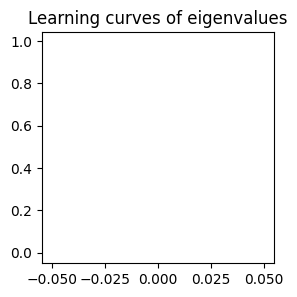

iteration: 10000 cost: -15.524299621582031 running time: 360.12


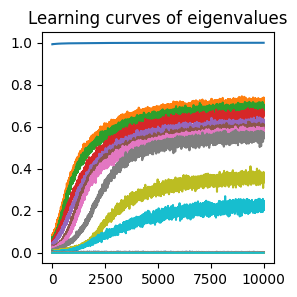

iteration: 20000 cost: -15.959892272949219 running time: 352.76


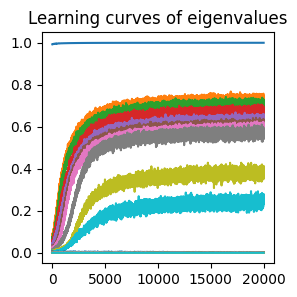

KeyboardInterrupt: 

In [5]:
run_experiments(30000) ### PLEASE RUN THIS EXPERIMENT FOR 100000 ITERARTIONS!

# Using this for our use-case?

In [6]:
from mashspud.SPUD import SPUD
from Main.test_manifold_algorithms import test_manifold_algorithms as tma 

dc = tma("iris.csv", verbose=4)

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


RF-GAP score is accuracy
RF score on full embedding: 0.9533333333333334
Cross Embedding score: None
Fraction of Samples Closest to thier Match: 0.0004888888888888889


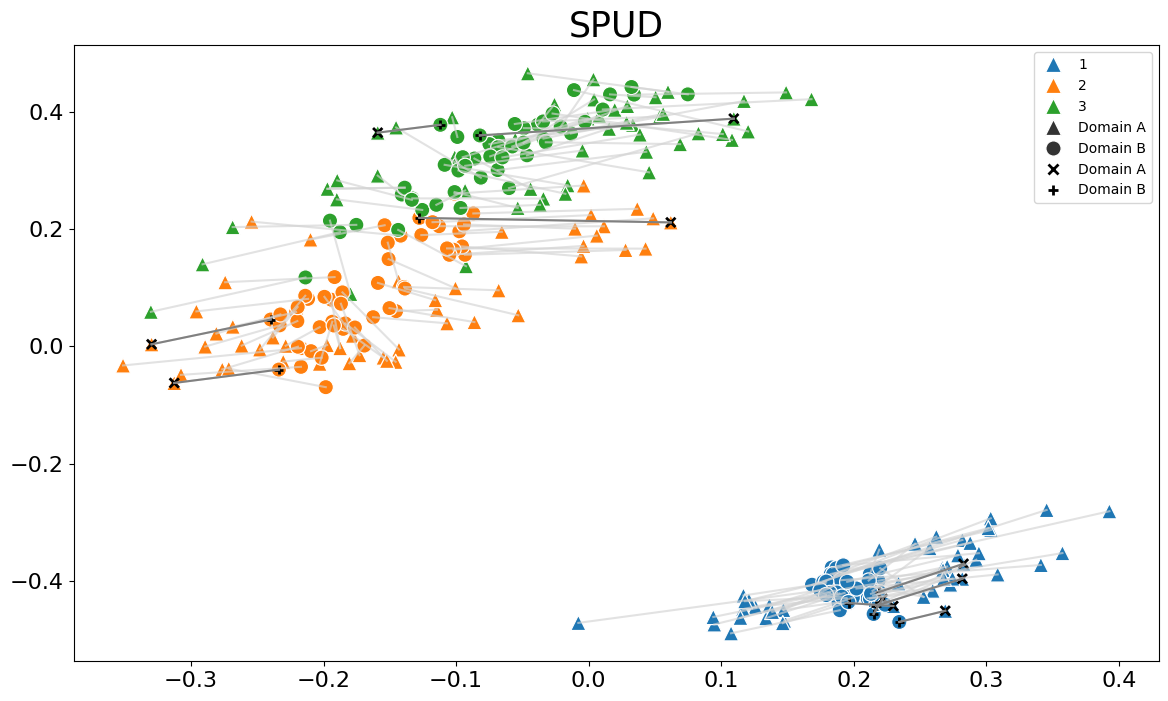

In [7]:
spud = SPUD(knn=5,  verbose=2)
spud.fit(dc.split_A, dc.split_B, dc.anchors[:10])
spud.plot_emb(labels=dc.labels_doubled)

iteration: 1 cost: -5.0880889892578125 running time: 0.09


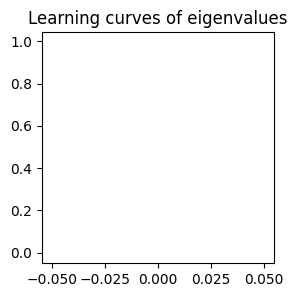

iteration: 10000 cost: -7.553260803222656 running time: 358.76


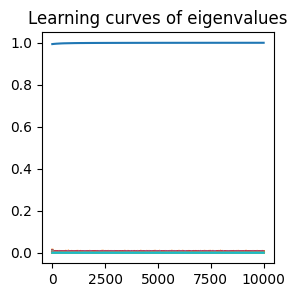

iteration: 20000 cost: -7.7714385986328125 running time: 365.65


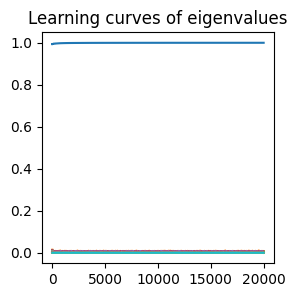

In [8]:
""" FIRST TEST RUN WITH MANIFOLD :)
I think for this to work for our use case, we simply just have to replace data with a given embedding. 
"""
data = spud.emb

X = data[:, 0]
Y = data[:, 1]

SAMPLE_X = torch.nn.functional.one_hot(torch.from_numpy(X).view(-1).to(torch.int64), num_classes=10).float().view(X.shape[0], -1)
SAMPLE_Y = torch.nn.functional.one_hot(torch.from_numpy(Y).view(-1).to(torch.int64), num_classes=10).float().view(Y.shape[0], -1)


run_experiments(30000)

In [11]:
len(eig_list), np.array(eig_list).shape

(29999, (29999, 20))

In [13]:
eig_list = np.load('/yunity/arusty/Graph-Manifold-Alignment/Results/MCA/eig_list.npy', allow_pickle=True)


In [15]:
eig_list[0]

array([9.9322617e-01, 1.4699979e-02, 1.2787954e-02, 1.2218752e-02,
       1.0110284e-02, 8.5921045e-03, 7.2612492e-03, 6.1272327e-03,
       5.1569128e-03, 4.5595621e-03, 2.9576402e-03, 2.3997733e-03,
       1.8449379e-03, 1.6116697e-03, 1.0908073e-03, 5.6712993e-04,
       4.5420497e-04, 1.7358559e-04, 2.1976997e-05, 4.1793960e-06],
      dtype=float32)

These might be the eigenvectors on how to get to the embedding space. Maybe we would do predictions based on the neural networks we made? 